
# DBLP Anomaly Detection (Clustering)
Identify papers/authors whose topics deviate from venue norms.
- TF-IDF titles/abstracts to topic vectors.
- Cluster per venue (K-Means baseline; optional HDBSCAN if installed).
- Score distance to cluster centroids; flag far-out papers/authors.
- Visualize distance distributions and 2D projections.


In [18]:

from pathlib import Path
import json
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP


/Users/aisulutulyeujan/Desktop/UH/Fall 2025/COSC 3337/final project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Parameters
DATA_DIR = Path("data")
FILES = sorted(DATA_DIR.glob("dblp-ref-*.json"))
TOP_VENUE_N = 5
SAMPLE_LIMIT = None
MAX_FEATURES = 10000
NGRAM_RANGE = (1, 2)
MIN_VENUE_ROWS = 200
N_CLUSTERS = 3
DISTANCE_Z_CUTOFF = 2.5
RANDOM_STATE = 42

In [3]:

def iter_records(files):
    for fp in files:
        with fp.open() as f:
            for line in f:
                if not line.strip():
                    continue
                try:
                    yield json.loads(line)
                except json.JSONDecodeError:
                    continue

def clean_text(v):
    if v is None:
        return None
    t = str(v).strip()
    return t if t else None


## Venue counts

In [4]:

venue_counts = Counter()
for rec in iter_records(FILES):
    venue = clean_text(rec.get("venue"))
    if venue:
        venue_counts[venue] += 1

venue_df = (
    pd.DataFrame({"venue": list(venue_counts.keys()), "papers": list(venue_counts.values())})
    .sort_values("papers", ascending=False)
    .reset_index(drop=True)
)
venue_df.head(5)


,venue,papers
0,Lecture Notes in Computer Science,32137
1,"international conference on acoustics, speech,...",26621
2,international conference on robotics and autom...,19943
3,international conference on image processing,18336
4,international conference on communications,17679


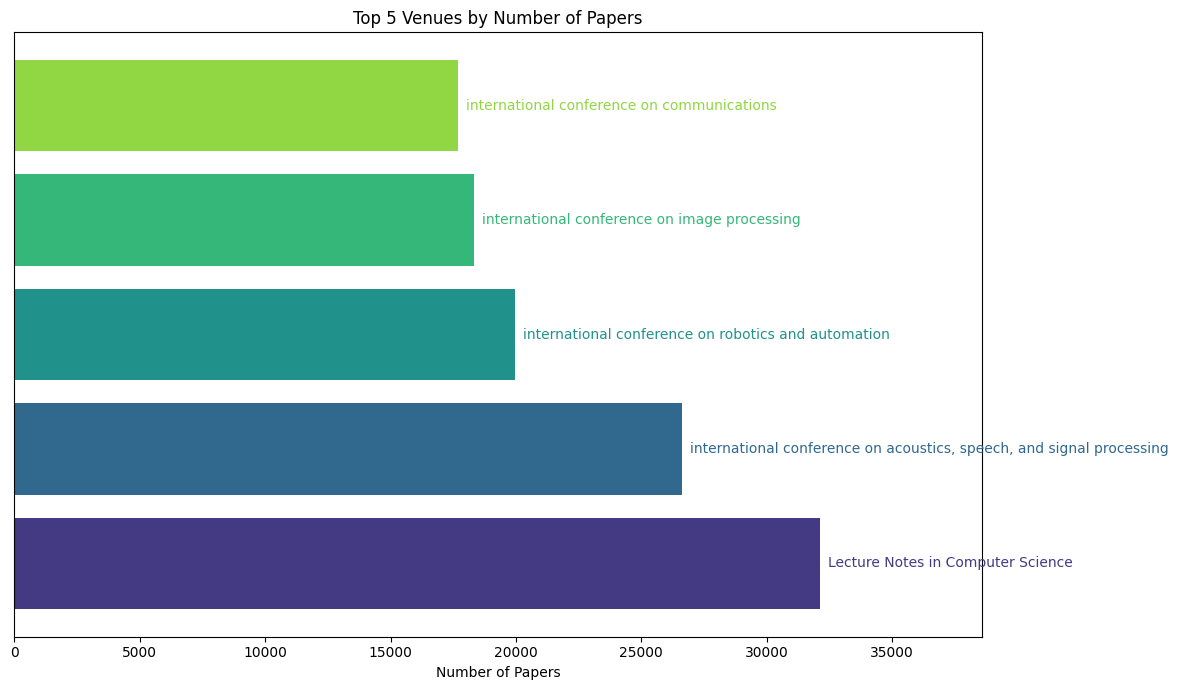

In [5]:
# Bar plot: #papers per chosen venue

top_venues = venue_df.head(TOP_VENUE_N)
counts = top_venues["papers"].tolist()
colors = sns.color_palette("viridis", len(top_venues))
plt.figure(figsize=(12, 7))
bars = plt.barh(range(len(top_venues)), counts, color=colors)
plt.yticks([])
for i, (venue, color) in enumerate(zip(top_venues["venue"], colors)):
    plt.text(
        counts[i] + max(counts)*0.01,
        i,
        venue,
        va='center',
        color=color,
        fontsize=10
    )
plt.xlabel("Number of Papers")
plt.title(f"Top {TOP_VENUE_N} Venues by Number of Papers")
plt.xlim(0, max(counts)*1.2)
plt.tight_layout()
plt.show()


## Load target venues

In [6]:

target_venues = set(venue_df.head(TOP_VENUE_N)["venue"])
rows = []
for rec in iter_records(FILES):
    venue = clean_text(rec.get("venue"))
    if venue not in target_venues:
        continue
    title = clean_text(rec.get("title")) or ""
    abstract = clean_text(rec.get("abstract")) or ""
    text = f"{title} {abstract}".strip()
    rows.append({
        "title": title,
        "abstract": abstract,
        "text": text,
        "venue": venue,
    })
    if SAMPLE_LIMIT is not None and len(rows) >= SAMPLE_LIMIT:
        break

df = pd.DataFrame(rows)
df.shape


(114716, 4)

## TF-IDF vectorization

In [12]:

vec = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM_RANGE, min_df=2)
X = vec.fit_transform(df["text"])
feature_names = vec.get_feature_names_out()

## Cluster per venue and score distances by K-means

In [8]:

all_anoms = []
venue_stats = []
for venue, idxs in df.groupby("venue").groups.items():
    idxs = list(idxs)
    if len(idxs) < MIN_VENUE_ROWS:
        continue
    Xv = X[idxs]
    km = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(Xv)
    centers = km.cluster_centers_
    # distance to assigned centroid
    dists = np.linalg.norm(Xv - centers[labels], axis=1)
    z = (dists - dists.mean()) / (dists.std() + 1e-9)
    anom_mask = z > DISTANCE_Z_CUTOFF
    venue_df_subset = df.iloc[idxs].copy()
    venue_df_subset["cluster"] = labels
    venue_df_subset["dist"] = dists
    venue_df_subset["dist_z"] = z
    venue_df_subset["is_anom"] = anom_mask
    all_anoms.append(venue_df_subset[venue_df_subset["is_anom"]])
    venue_stats.append({"venue": venue, "rows": len(idxs), "anomalies": int(anom_mask.sum())})

anoms = pd.concat(all_anoms) if all_anoms else pd.DataFrame()
stats_df = pd.DataFrame(venue_stats).sort_values("anomalies", ascending=False)
stats_df.head(10)


,venue,rows,anomalies
2,international conference on communications,17679,447
3,international conference on image processing,18336,397
1,"international conference on acoustics, speech,...",26621,363
4,international conference on robotics and autom...,19943,214
0,Lecture Notes in Computer Science,32137,201


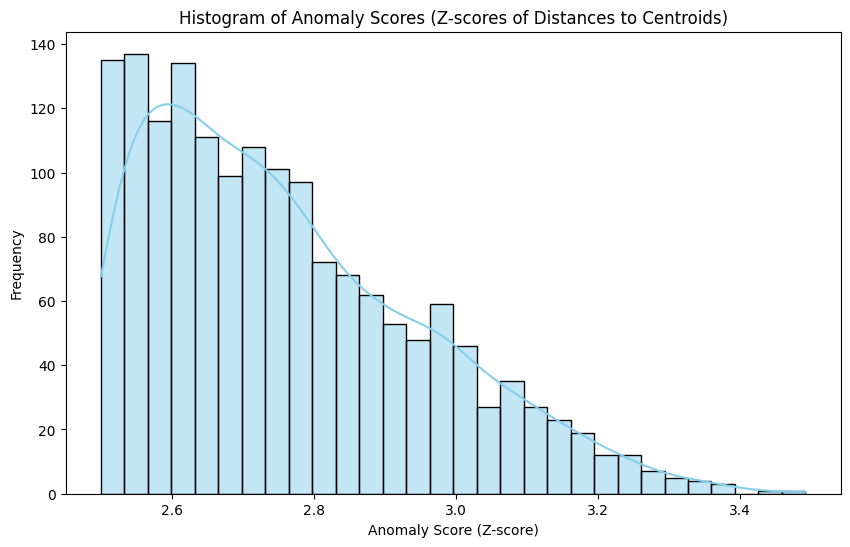

Total Papers: 114716
Total Anomalies Detected: 1622
Percentage of Anomalies: 1.41%


In [ ]:
# Histogram or boxplot of anomaly scores.
plt.figure(figsize=(10, 6))
sns.histplot(anoms["dist_z"], bins=30, kde=True, color='skyblue')
plt.title("Histogram of Anomaly Scores (Z-scores of Distances to Centroids)")
plt.xlabel("Anomaly Score (Z-score)")
plt.ylabel("Frequency")
plt.show()

# How many anomalies you found
total_rows = df.shape[0]
total_anomalies = anoms.shape[0]
anomaly_percentage = (total_anomalies / total_rows) * 100 if total_rows > 0 else 0
print(f"Total Papers: {total_rows}")
print(f"Total Anomalies Detected: {total_anomalies}")
print(f"Percentage of Anomalies: {anomaly_percentage:.2f}%")

## Top anomalies

In [9]:

anoms[["venue", "title", "dist_z", "cluster"]].sort_values("dist_z", ascending=False).head(20)


,venue,title,dist_z,cluster
99766,"international conference on acoustics, speech,...",Expert Summaries,3.491971,2
99177,international conference on image processing,LQ-bundle adjustment.,3.438630,2
628,international conference on image processing,DVD: Redefining Multimedia (Abstract).,3.389418,2
554,international conference on communications,International Standards Activities Shaping ISDN.,3.371354,0
36926,"international conference on acoustics, speech,...",Joint precoding over a master-slave coordinati...,3.360489,2
99614,international conference on image processing,A conjointly well localized quadrature mirror ...,3.351502,2
99882,international conference on image processing,Supervised fractional eigenfaces.,3.350705,2
37612,"international conference on acoustics, speech,...",KEOPS: Kernels organized into pyramids,3.347169,2
100031,international conference on image processing,BIT: Bio-inspired tracker,3.338726,2
109925,international conference on image processing,General chair's welcome,3.324567,2


## Visualizations

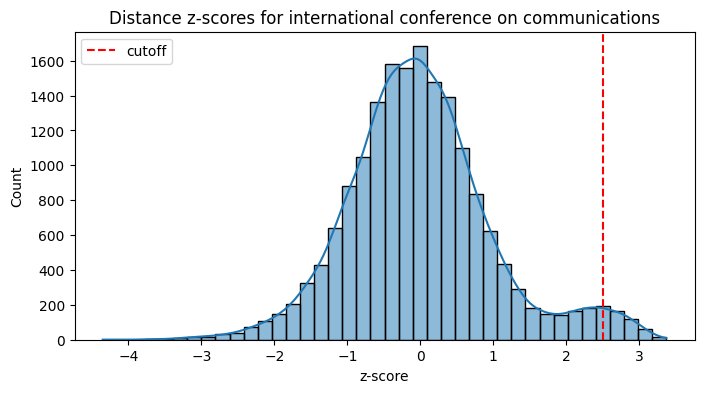

In [20]:

# Distance distribution for a sample venue
sample_venue = stats_df.iloc[0]["venue"] if not stats_df.empty else None
if sample_venue:
    idxs = list(df[df["venue"] == sample_venue].index)
    Xv = X[idxs]
    km = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(Xv)
    centers = km.cluster_centers_
    dists = np.linalg.norm(Xv - centers[labels], axis=1)
    z = (dists - dists.mean()) / (dists.std() + 1e-9)

    plt.figure(figsize=(8,4))
    sns.histplot(z, bins=40, kde=True)
    plt.axvline(DISTANCE_Z_CUTOFF, color='r', linestyle='--', label='cutoff')
    plt.title(f"Distance z-scores for {sample_venue}")
    plt.xlabel("z-score")
    plt.legend()
    plt.show()

/Users/aisulutulyeujan/Desktop/UH/Fall 2025/COSC 3337/final project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


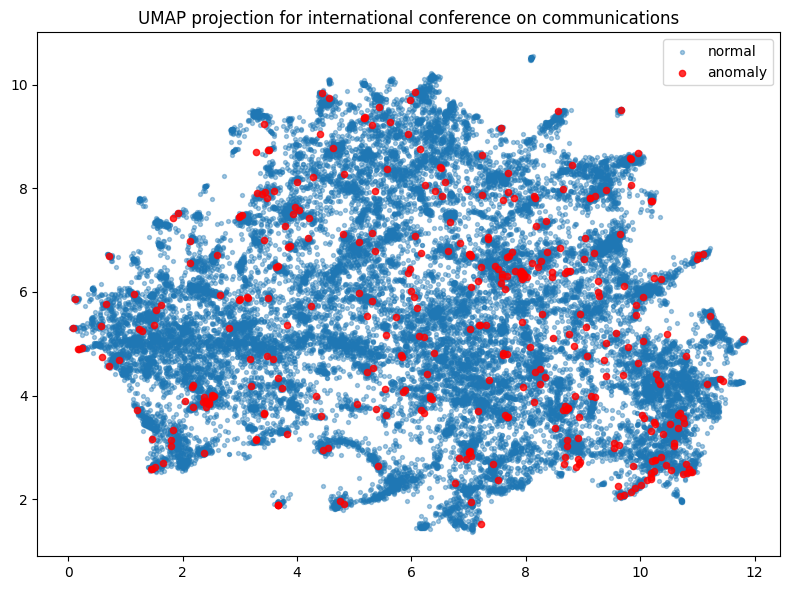

In [ ]:
# UMAP 2D projection with anomalies highlighted
umap = UMAP(
    n_components=2,
    random_state=RANDOM_STATE,
    n_neighbors=15,  
    min_dist=0.1, 
    metric="cosine"
)

Xp = umap.fit_transform(Xv)

mask = z > DISTANCE_Z_CUTOFF

plt.figure(figsize=(8, 6))
plt.scatter(Xp[~mask, 0], Xp[~mask, 1],
            s=8, alpha=0.4, label='normal')
plt.scatter(Xp[mask, 0], Xp[mask, 1],
            s=20, color='red', alpha=0.8, label='anomaly')
plt.title(f"UMAP projection for {sample_venue}")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
sample_anoms = anoms[anoms["venue"] == sample_venue].sort_values("dist_z", ascending=False).head(1)
for idx, row in sample_anoms.iterrows():
    title = row["title"]
    venue = row["venue"]
    dist_z = row["dist_z"]
    cluster = row["cluster"]

    X_row = X[idx]
    top_indices = X_row.toarray().flatten().argsort()[-10:][::-1]
    top_keywords = [feature_names[i] for i in top_indices]

    print(f"Title: {title}")
    print(f"Venue: {venue}")
    print(f"Anomaly Score (Z): {dist_z:.2f}")
    print(f"Cluster: {cluster}")
    print(f"Top Keywords: {', '.join(top_keywords)}")

print("Explanation: This paper is unusual because it focuses on\n " \
"ISDN standardization activities, which is not a common topic \n " \
"within this venue. Most ICC papers cover communication systems,\n" \
" wireless technologies, and signal processing, not standards development.")
print("-" * 80)


Title: International Standards Activities Shaping ISDN.
Venue: international conference on communications
Anomaly Score (Z): 3.37
Cluster: 0
Top Keywords: international, shaping, standards, activities, zone, for tracking, for video, for very, for various, for use
Explanation: This paper is unusual because it focuses on
 ISDN standardization activities, which is not a common topic 
 within this venue. Most ICC papers cover communication systems,
 wireless technologies, and signal processing, not standards development.
--------------------------------------------------------------------------------
